In [1]:
from matplotlib import pyplot as plt
import os
import pandas as pd
import requests
import seaborn as sn
import sys
import zipfile

%matplotlib inline

def check_download_extract(url):
    zip_name = url[url.rfind('/') + 1:]
    csv_name = zip_name[:zip_name.rfind('.zip')]
    if os.path.isfile(csv_name):
        print("{} found".format(csv_name))
    else:
        print("Downloading {}...".format(zip_name))
        r = requests.get(url)

        if os.path.isfile(zip_name):
            os.remove(zip_name)

        with open(zip_name, 'wb') as f:
            f.write(r.content)

        print("Extracting {} from {}...".format(csv_name, zip_name))
        with zipfile.ZipFile(zip_name) as z:
            z.extractall()

        if os.path.isfile(csv_name):
            os.remove(zip_name)
            print("{} successfully extracted\n".format(csv_name))
        else:
            print("Error getting csv from {}".format(url))
            sys.exit(1)

    return csv_name

def convert_f_str(x):
    return float(x.rstrip('%'))

In [2]:
loan_url = 'https://resources.lendingclub.com/LoanStats3a.csv.zip'
declined_url = 'https://resources.lendingclub.com/RejectStatsA.csv.zip'

# Download csv files
loan_csv = check_download_extract(loan_url)
declined_csv = check_download_extract(declined_url)

# Load loan data, skip first and last 2 rows
loan_df = pd.read_csv(loan_csv, skiprows=1, skipfooter=2, engine='python')

# Drop all columns that contain all null values or a single value

for col in loan_df:
    if loan_df[col].isnull().all() or len(loan_df[col].value_counts()) == 1:
        loan_df = loan_df.drop(col, axis=1)

# Bad entry
loan_df = loan_df.drop(39786)

# Convert interest rate to float
loan_df['int_rate'] = loan_df['int_rate'].str.rstrip('%').astype('float')
loan_df = loan_df.reset_index().drop('index', axis=1)
loan_df['approved'] = 'Y'

# Load declined data, skip first row
declined_df = pd.read_csv(declined_csv, skiprows=1, converters={'Debt-To-Income Ratio': convert_f_str}).drop('Loan Title', axis=1)
declined_df = declined_df.rename({'Debt-To-Income Ratio': 'dti', 'State': 'addr_state', 'Employment Length': 'emp_length',
                                  'Amount Requested': 'loan_amnt'}, axis=1)

declined_df = declined_df.reset_index().drop('index', axis=1)
declined_df['approved'] = 'N'

# Bad entry > 100% and < 0%
declined_df = declined_df[declined_df.dti <= 100]
declined_df = declined_df[declined_df.dti >= 0]

# Combined data on approved, addr_state, emp_length, dti, loan_amnt
combined = pd.concat([loan_df, declined_df], ignore_index=True, join='inner').dropna().reset_index().drop('index', axis=1)

LoanStats3a.csv found
RejectStatsA.csv found


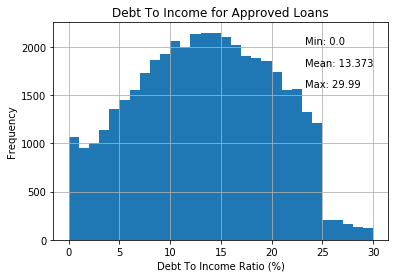

In [3]:
loan_df.dti.hist(bins=30)
plt.xlabel("Debt To Income Ratio (%)")
plt.ylabel("Frequency")
plt.title("Debt To Income for Approved Loans")
plt.annotate("Min: {}".format(round(loan_df.dti.min(), 4)), (0.75, 0.9), xycoords='axes fraction')
plt.annotate("Mean: {}".format(round(loan_df.dti.mean(), 4)), (0.75, 0.8), xycoords='axes fraction')
plt.annotate("Max: {}".format(round(loan_df.dti.max(), 4)), (0.75, 0.7), xycoords='axes fraction')
plt.show()

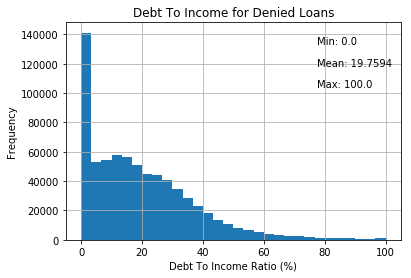

In [4]:
declined_df.dti.hist(bins=30)
plt.xlabel("Debt To Income Ratio (%)")
plt.ylabel("Frequency")
plt.title("Debt To Income for Denied Loans")
plt.annotate("Min: {}".format(round(declined_df.dti.min(), 4)), (0.75, 0.9), xycoords='axes fraction')
plt.annotate("Mean: {}".format(round(declined_df.dti.mean(), 4)), (0.75, 0.8), xycoords='axes fraction')
plt.annotate("Max: {}".format(round(declined_df.dti.max(), 4)), (0.75, 0.7), xycoords='axes fraction')
plt.show()